In [ ]:
using Pkg
Pkg.activate("../")

using StatsFuns
using Revise
using HiddenMarkovModel

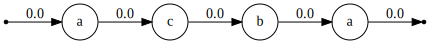

In [14]:
emissionsmap = Dict(
    "a" => 1,
    "b" => 2,
    "c" => 3,
    "d" => 4
)
sequence = ["a", "c", "b", "a"]
g1 = LinearGraph(sequence, emissionsmap)

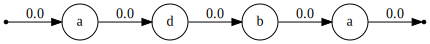

In [15]:
sequence = ["a", "d", "b", "a"]
g2 = LinearGraph(sequence, emissionsmap)

weightnormalize(g2)

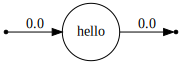

In [16]:
g3 = Graph()
s1 = addstate!(g3, State(1, 1, "hello"))
link!(initstate(g3), s1)
link!(s1, finalstate(g3))
g3

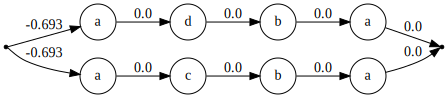

In [17]:
g = union(g1, g2)

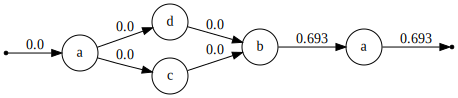

In [18]:
g |> minimize

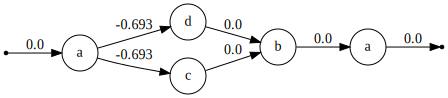

In [19]:
g = g |> minimize |> determinize |> weightnormalize

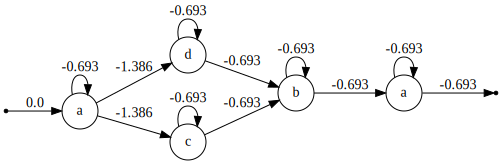

In [20]:
g = addselfloop(g) |> weightnormalize

In [ ]:
for (sid, state) in g.states
    println("state $(state) : $(state.incoming)")
    println("---")
end

In [21]:
D,N = 4,7 # number of distributions times number of frames
llh = randn(D, N)

4×7 Array{Float64,2}:
 -0.0219444  -0.834881   -1.84919   …   0.769205  -0.258161  -1.08763
  1.6688     -0.591582    1.82893       0.729571   1.53279   -1.09587
 -1.55903    -0.0274154  -0.226122     -0.86991    1.50731   -0.0142478
 -0.39818    -0.820911    1.26708      -1.4941     1.65603    0.876237

In [22]:
α = αrecursion(g, llh; pruning=nopruning) # the lower the more pruning 
α

[n = 1]	a = -0.022  
[n = 2]	a = -1.550  c = -1.436  d = -2.229  
[n = 3]	a = -4.092  c = -2.051  d = -0.151  b = 1.599  
[n = 4]	a = -6.073  c = -4.059  d = 1.108  a = -0.381  b = 0.777  
[n = 5]	a = -5.996  c = -5.594  d = -1.079  a = 1.370  b = 2.180  
[n = 6]	a = -6.948  c = -3.860  d = -0.097  a = 1.524  b = 3.191  
[n = 7]	a = -8.729  c = -4.545  d = 0.087  a = 1.472  b = 1.415  


In [23]:
β = βrecursion(g, llh; pruning=nopruning) # the lower the more pruning 
β

[n = 1]	a = -0.657  c = -1.254  d = -0.612  a = -9.400  b = -2.367  
[n = 2]	a = -0.091  c = -0.931  d = 0.712  a = -7.872  b = -1.083  
[n = 3]	a = -0.800  c = -1.964  d = -0.043  a = -5.329  b = -2.220  
[n = 4]	a = -3.461  c = -1.284  d = -1.355  a = -3.349  b = -1.305  
[n = 5]	c = -1.634  d = -1.634  a = -3.425  b = -1.480  
[n = 6]	a = -2.474  b = -2.474  
[n = 7]	a = -0.693  


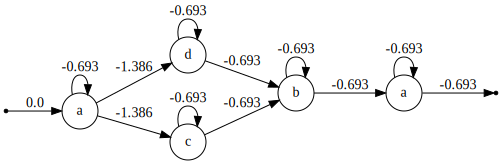

In [24]:
g

In [48]:
lnαβ = αβrecursion(g, llh) # the lower the more pruning 

[n = 1]	a = 0.000  
[n = 2]	a = -0.961  c = -1.688  d = -0.838  
[n = 3]	a = -5.219  c = -4.341  d = -0.521  b = -0.948  
[n = 4]	a = -9.870  c = -5.679  d = -0.583  a = -4.067  b = -0.865  
[n = 5]	c = -8.021  d = -3.506  a = -2.848  b = -0.092  
[n = 6]	a = -1.840  b = -0.173  
[n = 7]	a = 0.000  


In [44]:
for i in 1:length(lnαβ)
    filter!(p -> isfinite(p.second), lnαβ[i])
end
lnαβ

[n = 1]	a = 0.000  
[n = 2]	a = -0.961  c = -1.688  d = -0.838  
[n = 3]	a = -5.219  c = -4.341  d = -0.521  b = -0.948  
[n = 4]	a = -9.870  c = -5.679  d = -0.583  a = -4.067  b = -0.865  
[n = 5]	c = -8.021  d = -3.506  a = -2.848  b = -0.092  
[n = 6]	a = -1.840  b = -0.173  
[n = 7]	a = 0.000  


In [30]:
-Inf - -Inf

NaN

In [15]:
emissionsmap

Dict{String,Int64} with 4 entries:
  "c" => 3
  "b" => 2
  "a" => 1
  "d" => 4

State[State(id = 5, pdfindex = 1, a)]
[0.7790736854028112]
-----
State[State(id = 5, pdfindex = 1, a), State(id = 7, pdfindex = 2, b)]
[-0.9495710314383035, 0.7173805490978098]
-----
State[State(id = 2, pdfindex = 3, c), State(id = 6, pdfindex = 4, d), State(id = 7, pdfindex = 2, b)]
[-7.228687026933145, -2.7130561374235898, 0.5459813247208423]
-----
State[State(id = 2, pdfindex = 3, c), State(id = 6, pdfindex = 4, d), State(id = 7, pdfindex = 2, b)]
[-5.656790850022137, -0.4894713260516621, -0.8212208025472277]
-----
State[State(id = 8, pdfindex = 1, a), State(id = 6, pdfindex = 4, d)]
[-5.186357368915606, -0.5517706994160569]
-----
State[State(id = 8, pdfindex = 1, a), State(id = 6, pdfindex = 4, d)]
[-2.070088755335128, -2.056119361366472]
-----
State[State(id = 8, pdfindex = 1, a), State(id = 6, pdfindex = 4, d)]
[-2.0561193613664726, -Inf]
-----


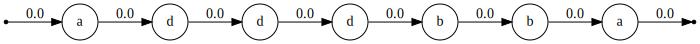

In [31]:
path = viterbi(g, llh)